# Capstone Project

## Analyzing the various regions in New Brunswick to start a convenience store

#### By Pruthvi Brahmbhatt

The following notebook includes the codework involved in reaching our conclusions from the report

Importing required packages

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
import folium
from bs4 import BeautifulSoup
import requests
import urllib.parse
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans

### Constructing the Dataset

Accessing postal code and the associated Forward Station Area(FSA) for New Brunswick, Canada via Wikipedia

In [3]:
#url containing information
url= 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_E'
#get request to access the html file
page=requests.get(url).text
#creating soup object
soup = BeautifulSoup(page,'html.parser')

Creating dataframe of collected information

In [4]:
#constructing empty list
table_contents=[]
#accessing table in html
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['Postal Code'] = row.span.text[0:3]
        cell['Location'] = (row.span.text[3:])
        table_contents.append(cell)

#creating dataframe
nb_data=pd.DataFrame(table_contents)
#editing certain names
nb_data['Location']=nb_data['Location'].replace({'MonctonEast(Dieppe)':'Moncton East (Dieppe)','MonctonNorthwest':'Moncton Northwest',
                                     'FrederictonNorth':'Fredericton North','MonctonWest':'Moncton West',
                                     'FrederictonSouth':'Fredericton South','MonctonCentral':'Moncton Central',
                                     'FrederictonSouthwest(New Maryland)':'Fredericton Southwest (Maryland)',
                                     'Saint JohnNortheast(Renforth)':'Saint John Northeast','Moncton Northern Outskirts (Lakeville / Shediac Bridge-Shediac River)':'Lakeville',
                                     'Saint JohnCentral':'Saint John Central','Saint JohnWest':'Saint John West',
                                     'Saint JohnRed Head':'Red Head','Saint JohnGrandview':'Grandview',
                                     'MiramichiEast(Chatham)':'Miramichi East','Saint JohnLakewood':'Lakewood','MiramichiWest(Newcastle)':'Miramichi West',
                                     'Grand FallsNortheast':'Grand Falls Northeast','Saint JohnLoch Lomond':'Loch Lomond',
                                     'Saint JohnEast':'Saint John East','Saint JohnNorth':'Saint John North','Alma Hillsborough Riverside-Albert':'Hillsborough'})
nb_data.reset_index(inplace=True)
nb_data

,index,Postal Code,Location
0,0,E1A,Moncton East (Dieppe)
1,1,E2A,Bathurst
2,2,E3A,Fredericton North
3,3,E4A,Chipman
4,4,E5A,Moores Mills
...,...,...,...
175,175,E5Z,Not assigned
176,176,E6Z,Not assigned
177,177,E7Z,Not assigned
178,178,E8Z,Not assigned


In [4]:
nb_data.shape

(180, 3)

Now we move on to obtaining the location data via Nominatim, for each of the FSA obtained 

In [5]:
#function to obtain location data given list of area
def getlatlong(column):
    latlist=[]
    longlist=[]
    i=0
    for name in column:
        address="{}, New Brunswick, Canada".format(name)
        url = 'https://nominatim.openstreetmap.org/search/' + urllib.parse.quote(address) +'?format=json'
        response = requests.get(url).json()
        
        if response==[]:
            latlist.append(float("NaN"))
            longlist.append(float("NaN"))
        else:
            latlist.append(response[0]['lat'])
            longlist.append(response[0]['lon'])
    return latlist,longlist
#Obtaining the location data from our dataframe nb_data
nb_data["Latitude"],nb_data["Longitude"]=getlatlong(nb_data['Location'])

In [6]:
nb_data.drop_duplicates("Location",inplace=True)
nb_data.shape

(111, 5)

Removing those rows for which the information could not be obtained

In [8]:
nb_data.dropna(axis=0,inplace=True)
nb_data.reset_index(inplace=True)
nb_data.drop(['index'],axis=1,inplace=True)
nb_data

,level_0,Postal Code,Location,Latitude,Longitude
0,0,E1A,Moncton East (Dieppe),46.11647835,-64.67556069377879
1,1,E2A,Bathurst,47.626529,-65.654297
2,2,E3A,Fredericton North,45.947959350000005,-66.65336235897576
3,3,E4A,Chipman,46.1778309,-65.8774732
4,4,E5A,Moores Mills,45.2863562,-67.2888138
...,...,...,...,...,...
105,153,E1X,Tracadie-Sheila,47.5146399,-64.90893552417663
106,156,E4X,St-Louis-de-Kent,46.7377084,-64.9719715
107,164,E3Y,Grand Falls Northeast,47.0463119,-67.7393601
108,165,E4Y,Rogersville,46.73286,-65.4255381


In [10]:
#Obtaining geographical coordinates for New Brunswick
address = 'New Brunswick, Canada'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of NB are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of NB are 46.500283, -66.750183.


Creating a map of New Brunswick with markers for each of the FSA's

In [11]:
#Map of New Brunswick
map_nb = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(nb_data['Latitude'], nb_data['Longitude'], nb_data['Location']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nb)  
    
map_nb

### Obtaining venue information

Including foursquare information

In [12]:
#Foursquare Credentials
CLIENT_ID = '00BG5SKDP13U2DMGILURXZVKOSNC5JPNXRFEXBK51LMD0JUI' # your Foursquare ID
CLIENT_SECRET = 'RUZOSL4MDLMIN4FZD5DEM1TN2DOIDIFDUOX4PVLGZ3I1BPQE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

Creating a function to access venues list from each area

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Location Latitude', 
                  'Location Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Accessing venues from each location of our dataframe

In [39]:
final_venues = getNearbyVenues(names=nb_data['Location'],
                                   latitudes=nb_data['Latitude'],
                                   longitudes=nb_data['Longitude']
                                  )

In [40]:
final_venues

,Location,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Moncton East (Dieppe),46.11647835,-64.67556069377879,TriStar Mercedes-Benz Moncton,46.123225,-64.683409,Auto Dealership
1,Moncton East (Dieppe),46.11647835,-64.67556069377879,Greater Moncton International Airport (YQM) (G...,46.116169,-64.688426,Airport
2,Moncton East (Dieppe),46.11647835,-64.67556069377879,Moncton Airport Security checkpoint,46.116188,-64.688283,Airport Service
3,Moncton East (Dieppe),46.11647835,-64.67556069377879,Post Security Lounge,46.116221,-64.688389,Airport Lounge
4,Moncton East (Dieppe),46.11647835,-64.67556069377879,Avis Car Rental,46.116349,-64.688412,Rental Car Location
...,...,...,...,...,...,...,...
999,Rogersville,46.73286,-65.4255381,Pizza Delight,46.736983,-65.430956,Pizza Place
1000,Petitcodiac,45.9361658,-65.1759490204391,Tim Hortons,45.931528,-65.168804,Coffee Shop
1001,Petitcodiac,45.9361658,-65.1759490204391,Foodland - Petitcodiac,45.931855,-65.175998,Grocery Store
1002,Petitcodiac,45.9361658,-65.1759490204391,Circle K,45.932447,-65.168782,Convenience Store


Obtaining the number of venues grouped by location

In [41]:
final_venues.groupby('Location').count()

,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Location,,,,,,
Allardville,2,2,2,2,2,2
Apohaqui,1,1,1,1,1,1
Baie-Sainte-Anne,3,3,3,3,3,3
Balmoral,2,2,2,2,2,2
Bath,3,3,3,3,3,3
...,...,...,...,...,...,...
St. Stephen,11,11,11,11,11,11
Stanley,3,3,3,3,3,3
Sussex,12,12,12,12,12,12


In [42]:
print('There are {} uniques categories.'.format(len(final_venues['Venue Category'].unique())))

There are 137 uniques categories.


### Performing K-Means Clustering

In [43]:
# one hot encoding
final_onehot = pd.get_dummies(final_venues[['Venue Category']], prefix="", prefix_sep="")

# add location column back to dataframe
final_onehot['Location'] = final_venues['Location'] 

# move location column to the first column
fixed_columns = [final_onehot.columns[-1]] + list(final_onehot.columns[:-1])
final_onehot = final_onehot[fixed_columns]

final_onehot.head(10)

,Location,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Train Station,Vacation Rental,Video Game Store,Waterfall,Wine Bar,Women's Store
0,Moncton East (Dieppe),0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Moncton East (Dieppe),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Moncton East (Dieppe),0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Moncton East (Dieppe),0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Moncton East (Dieppe),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Moncton East (Dieppe),0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Moncton East (Dieppe),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Moncton East (Dieppe),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Moncton East (Dieppe),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Moncton East (Dieppe),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
final_onehot.shape

(1004, 138)

In [46]:
#grouping by location and obtaining mean occurences
final_grouped = final_onehot.groupby('Location').mean().reset_index()
final_grouped

,Location,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Art Gallery,Asian Restaurant,Athletics & Sports,Auto Dealership,...,Theater,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Train Station,Vacation Rental,Video Game Store,Waterfall,Wine Bar,Women's Store
0,Allardville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Apohaqui,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Baie-Sainte-Anne,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Balmoral,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bath,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,St. Stephen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,Stanley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
90,Sussex,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,Tracadie-Sheila,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
#collecting only mean occurences of Convenience Store
constore_table = final_grouped[["Location","Convenience Store"]]
constore_table.head()

,Location,Convenience Store
0,Allardville,0.0
1,Apohaqui,0.0
2,Baie-Sainte-Anne,0.0
3,Balmoral,0.5
4,Bath,0.0


We perform an elbow test to check for optimal K value to be used

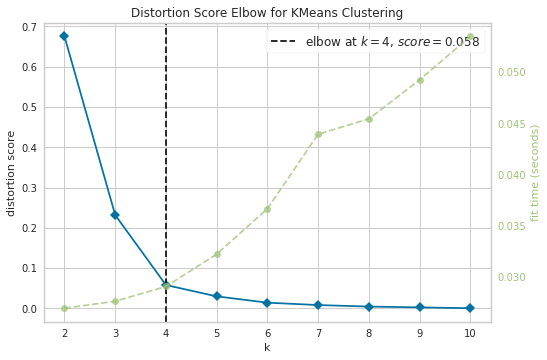

In [48]:
#elbow test to obtain optimal K value
model=KMeans()
elbow_visual=KElbowVisualizer(model,k=(2,11))

constore_table_clustering= constore_table.drop(['Location'],axis=1)
elbow_visual.fit(constore_table_clustering)
elbow_visual.show()

We perform the K-Means Clustering to obtain the final clusters

In [50]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(constore_table_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 2, 0, 2, 3, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2], dtype=int32)

Creating final merged dataset

In [65]:
# add clustering labels
final_merged = constore_table.copy()
final_merged["Cluster Labels"] = kmeans.labels_

final_merged = final_merged.join(final_venues.set_index('Location'), on='Location')

final_merged.reset_index().drop('index',axis=1) 

#removing NA values and obtaining shape
final_merged.dropna(inplace=True)
final_merged.head(10)

,Location,Convenience Store,Cluster Labels,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allardville,0.0,0,47.4747689,-65.4924217,Restaurant Special 7-4,47.474400,-65.491865,Restaurant
0,Allardville,0.0,0,47.4747689,-65.4924217,Epicerie Du Coin,47.474193,-65.491958,Grocery Store
1,Apohaqui,0.0,0,45.698347,-65.5984149,Apohaqui Inn,45.700128,-65.601677,Inn
2,Baie-Sainte-Anne,0.0,0,47.0472588,-64.9625674,BrokerLink,47.046437,-64.966822,Insurance Office
2,Baie-Sainte-Anne,0.0,0,47.0472588,-64.9625674,Proxim pharmacie affiliée,47.043194,-64.974368,Pharmacy
2,Baie-Sainte-Anne,0.0,0,47.0472588,-64.9625674,Guardian - Bay Pharmacy,47.042973,-64.974472,Pharmacy
3,Balmoral,0.5,1,47.9726771,-66.4453964,Resto Chez Madie,47.973981,-66.440265,Restaurant
3,Balmoral,0.5,1,47.9726771,-66.4453964,Depanneur Yatout,47.975966,-66.432701,Convenience Store
4,Bath,0.0,0,46.5119155,-67.5944492,The Diner Down Under,46.508859,-67.592276,Diner
4,Bath,0.0,0,46.5119155,-67.5944492,drost save easy,46.513366,-67.599499,Market


In [53]:
#Obtaining unique cluster list
final_merged['Cluster Labels'].unique()

array([0, 1, 2, 3], dtype=int32)

In [54]:
#counting number of instances for each cluster
final_merged.groupby("Cluster Labels").count()

,Location,Convenience Store,Location Latitude,Location Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Cluster Labels,,,,,,,,
0,933,933,933,933,933,933,933,933
1,11,11,11,11,11,11,11,11
2,59,59,59,59,59,59,59,59
3,1,1,1,1,1,1,1,1


Obtaining number of convenience stores in listed as a venue category

In [55]:
final_merged['Venue Category'].value_counts()['Convenience Store']

23

Creating a map with the clusters included

In [56]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_merged['Location Latitude'], final_merged['Location Longitude'], final_merged['Location'], final_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Attaching cluster labels to table containing mean of number of convenience stores

In [66]:
constore_table["Cluster Labels"] = kmeans.labels_
constore_table.head()

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Location,Convenience Store,Cluster Labels
0,Allardville,0.0,0
1,Apohaqui,0.0,0
2,Baie-Sainte-Anne,0.0,0
3,Balmoral,0.5,1
4,Bath,0.0,0


Plotting the number of locations per cluster 

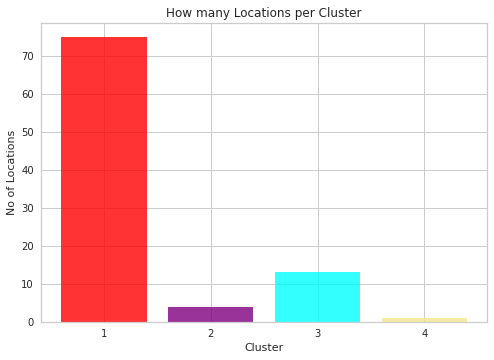

In [78]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = constore_table['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red','purple','cyan','khaki'])
plt.xticks(y_pos, objects)
plt.ylabel('No of Locations')
plt.xlabel('Cluster')
plt.title('How many Locations per Cluster')
plt.show()

In [79]:
constore_table['Cluster Labels'].value_counts()

0    75
2    13
1     4
3     1
Name: Cluster Labels, dtype: int64

### Cluster Analysis

#### Cluster 1 (Red)

In [84]:
cluster_1=final_merged.loc[final_merged['Cluster Labels'] == 0, final_merged.columns[[0,1,2] + list(range(5, final_merged.shape[1]))]]
cluster_1.reset_index()

,Location,Convenience Store,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category
49,Moncton Central,0.031250,0,Circle K,46.085569,-64.807102,Convenience Store
51,Moncton Northwest,0.031250,0,Circle K,46.085569,-64.807102,Convenience Store
52,Moncton West,0.031250,0,Circle K,46.085569,-64.807102,Convenience Store
90,Sussex,0.083333,0,Circle K,45.722621,-65.506368,Convenience Store


#### Cluster 2 (Purple)

In [81]:
cluster_2=final_merged.loc[final_merged['Cluster Labels'] == 1, final_merged.columns[[0,1,2] + list(range(5, final_merged.shape[1]))]]
cluster_2.reset_index()

,index,Location,Convenience Store,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category
0,3,Balmoral,0.5,1,Resto Chez Madie,47.973981,-66.440265,Restaurant
1,3,Balmoral,0.5,1,Depanneur Yatout,47.975966,-66.432701,Convenience Store
2,8,Boiestown,0.5,1,Circle K,46.456452,-66.417791,Convenience Store
3,8,Boiestown,0.5,1,Carr's Computer Service.,46.454861,-66.426926,Electronics Store
4,13,Cap-Pelé,0.4,1,Bel-Air Take Out,46.214923,-64.267940,Seafood Restaurant
5,13,Cap-Pelé,0.4,1,PJC Jean Coutu Santé-Beauté,46.217005,-64.282261,Pharmacy
6,13,Cap-Pelé,0.4,1,Circle K,46.215295,-64.269818,Convenience Store
7,13,Cap-Pelé,0.4,1,Doiron Market,46.214729,-64.269123,Convenience Store
8,13,Cap-Pelé,0.4,1,Fred's Bakery,46.215764,-64.291854,Bakery
9,14,Centreville,0.5,1,Grandma's,46.431306,-67.708973,Burger Joint


#### Cluster 3 (Cyan)

In [82]:
cluster_3=final_merged.loc[final_merged['Cluster Labels'] == 2, final_merged.columns[[0,1,2] + list(range(5, final_merged.shape[1]))]]
cluster_3.reset_index()

,index,Location,Convenience Store,Cluster Labels,Venue,Venue Latitude,Venue Longitude,Venue Category
0,9,Bouctouche,0.142857,2,Tim Hortons,46.466165,-64.731514,Coffee Shop
1,9,Bouctouche,0.142857,2,Forum de Bouctouche,46.472280,-64.721771,Hockey Arena
2,9,Bouctouche,0.142857,2,dixie lee,46.471701,-64.721616,Snack Place
3,9,Bouctouche,0.142857,2,Centre James K Irving,46.475277,-64.719850,Hockey Arena
4,9,Bouctouche,0.142857,2,Circle K,46.469035,-64.727952,Convenience Store
5,9,Bouctouche,0.142857,2,Irving arboretum,46.480613,-64.713317,Park
6,9,Bouctouche,0.142857,2,Co-Op Bouctouche,46.464003,-64.735503,Grocery Store
7,16,Cocagne,0.333333,2,Cocagne Marina,46.334442,-64.623896,Harbor / Marina
8,16,Cocagne,0.333333,2,Cocagne Variety,46.340042,-64.619507,Convenience Store
9,16,Cocagne,0.333333,2,Arena Cocagne,46.335390,-64.627404,Hockey Arena


#### Cluster 4 (Khaki)

In [63]:
cluster_4=final_merged.loc[final_merged['Cluster Labels'] == 3, final_merged.columns[[1] + list(range(5, final_merged.shape[1]))]]
cluster_4

,Convenience Store,Venue,Venue Latitude,Venue Longitude,Venue Category
19,1.0,B & L Convenience Store,46.569961,-66.103779,Convenience Store


Plotting average number of convenience store per cluster

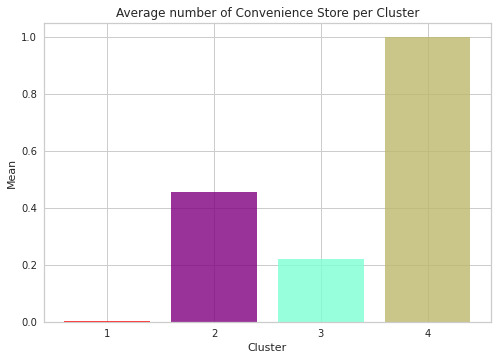

In [64]:
clusters_mean = [cluster_1['Convenience Store'].mean(),cluster_2['Convenience Store'].mean(),cluster_3['Convenience Store'].mean(),
                 cluster_4['Convenience Store'].mean()]
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
perf = clusters_mean
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['red', 'purple','aquamarine', 'darkkhaki'])
plt.xticks(y_pos, objects)
plt.ylabel('Mean')
plt.xlabel('Cluster')
plt.title('Average number of Convenience Store per Cluster')

plt.show()

### Observations

From our plot on the average number of convenience stores per cluster, we observe a reversal i.e. Cluster 4 comes first followed by Cluster 2, Cluster 3 and Cluster 1. In other words, Cluster 4 has a high number of convenience stores relative per location, whereas Cluster 1 has the lowest number of convenience stores per location.

This result therefore indicates that opening a convenience store in a location within Cluster 1 would be apt, given that there must exist atleast one location in this cluster that does not have a popular convenience store destination.